In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

In [2]:
recom_df = pd.read_pickle("data/recommendation_recipes.pkl")
recom_df

,name,ingredients,description,instructions,cuisine,course,diet,prep_time,categorized_prep_time,cleaned_ingredients,allergens,processed_name,processed_instructions,processed_description,allergen_type
0,Doddapatre Tambuli Recipe (Karpooravalli Thayi...,"4 cups Indian borage (Doddapatre) , cleaned an...",Doddapatre Tambuli Recipe is a popular healing...,"To begin making the Doddapatre Tambuli, first ...",Indian,Side Dish,Vegetarian,30.0,~30 min,"[indian borage doddapatre, curd dahi yogurt, c...",[yogurt],doddapatre tambuli karpooravalli thayir pachadi,doddapatre tambuli doddapatre leave dry towel ...,doddapatre tambuli popular healing cold yoghur...,[Dairy]
1,Fish Tandoori Recipe,"1 Fish , nicely washed with bones on (I used P...",Have you ever tried out fish tandoori? Trust m...,"To begin making the Fish Tandoori recipe, keep...",North Indian,Appetizer,High Protein Non Vegetarian,80.0,~1 hour 30 min,"[fish, curd dahi yogurt, onion, green chilli, ...",[fish],fish tandoori,fish tandoori head fin inside fish many horizo...,fish tandoori delicious chicken tandoori tando...,[Fish and Shellfish]
2,Arbi Shimla Mirch Sabzi Recipe – Colocasia Cap...,300 grams Colocasia root (Arbi) 1 Green Bell ...,Arbi Shimla Mirch Sabzi Recipe is a variation ...,To begin making the Arbi Shimla Mirch Sabzi Re...,North Indian,Main Course,No Onion No Garlic (Sattvic),55.0,~1 hour,"[colocasia root arbi, green bell pepper capsic...",[peanut],arbi shimla mirch sabzi colocasia capsicum sabzi,arbi shimla mirch sabzi arbi pressure pressure...,arbi shimla mirch sabzi variation aloo capsicu...,"[Tree Nuts and Peanuts, Legumes and Seeds]"
3,Ambur Style Brinjal Curry Recipe,5 Brinjal (Baingan / Eggplant) 1 Onion 2 Tom...,Brinjal Curry is prepared in different ways in...,To begin making the Ambur Style Brinjal Curry ...,Indian,Lunch,Vegetarian,20.0,~30 min,"[brinjal baingan eggplant, onion, ginger garli...","[sesame, mustard, peanut]",ambur style brinjal curry,ambur style brinjal curry oil heavy bottomed o...,brinjal curry different way different region s...,"[Legumes and Seeds, Tree Nuts and Peanuts]"
4,Mavinakayi Menasinakai Curry Recipe - Raw Man...,"1 cup Mango (Raw) , diced 2 tablespoons Jagge...",Mangalorean Mavinakayi Menasinakai Curry Recip...,To begin making Mangalorean Mavinakayi Menasin...,Mangalorean,Side Dish,Vegetarian,35.0,~45 min,"[mango, jaggery, turmeric powder, tamarind wat...",[sesame],mavinakayi menasinakai curry raw mango coconut...,mangalorean mavinakayi menasinakai curry raw m...,mangalorean mavinakayi menasinakai curry raw m...,[Legumes and Seeds]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9491,Spinach Oats Vada Recipe,"Spinach Leaves (Palak), Chana dal (Bengal Gram...",Spinach Oats Vada Recipe is a healthy twist to...,"To prepare Spinach Oats Vada Recipe, in a larg...",South Indian,Snack,Vegetarian,50.0,~1 hour,"[spinach palak, chana dal bengal gram dal, ins...",[oats],spinach oats vada,spinach oats vada large mixing ingredient vada...,spinach oats vada healthy twist vada superfood...,[Grains and Gluten]
9492,Kerala Style Vettu Cake Recipe (Eggless Wholew...,"Whole Wheat Flour, Sugar, Cooking soda, Butter...",Vettu cake is a famous tea shop snack in Tamil...,To prepare Kerala Style Vettu Cake Recipe (Egg...,Kerala,Snack,Vegetarian,65.0,~1 hour 15 min,"[whole wheat flour, sugar, soda, butter, salt,...","[wheat, egg, milk, butter]",kerala style vettu cake eggless wholewheat tea...,kerala style vettu cake eggless wholewheat tea...,vettu cake famous tea shop snack tamil nadu ke...,"[Grains and Gluten, Eggs, Dairy]"
9493,Amla/Nellikai Thogayal Recipe (Gooseberry Chut...,"Amla (Nellikai/ Gooseberry), Fresh coconut, Me...",The Gooseberry (Amla/Nellikai) Chutney recipe ...,"To begin making the Amla Thogayal, we will fir...",South Indian,Side Dish,Vegetarian,25.0,~30 min,"[amla nellikai gooseberry, fresh coconut, meth...",unknown,amla nellikai thogayal gooseberry chutney,amla thogayal gooseberry portion gooseberry cl...,gooseberr

In [3]:
# Convert each list in the 'cleaned_ingredient' column to a space-separated string to standardize the form of all precocessed colmuns. 
recom_df["processed_ingredients"] = recom_df['cleaned_ingredients'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)

# Combine all processed columns into a single column for topic modeling
recom_df['combined_context'] = recom_df['processed_name'] + ' ' + recom_df['processed_ingredients'] + ' ' + recom_df['processed_description'] + ' ' + recom_df['processed_instructions']
recom_df['combined_context']

0       doddapatre tambuli karpooravalli thayir pachad...
1       fish tandoori fish curd dahi yogurt onion gree...
2       arbi shimla mirch sabzi colocasia capsicum sab...
3       ambur style brinjal curry brinjal baingan eggp...
4       mavinakayi menasinakai curry raw mango coconut...
                              ...                        
9491    spinach oats vada spinach palak chana dal beng...
9492    kerala style vettu cake eggless wholewheat tea...
9493    amla nellikai thogayal gooseberry chutney amla...
9494    kanchakalar khosha bata traditional bengali ra...
9495    tomato onion chutney coconut mint onion green ...
Name: combined_context, Length: 9496, dtype: object

Train SVD model on TF-IDF and Count vectorizers and find the best number of topics using coherence scores

In [4]:
def compute_coherence_scores_svd(texts, vectorizer, num_topics_range):
    coherence_scores = []
    
    # Transform texts to TF-IDF matrix
    tfidf_matrix = vectorizer.fit_transform(texts)
    
    # Tokenize each text in `texts` for Gensim's coherence calculation
    tokenized_texts = [text.split() for text in texts]
    dictionary = Dictionary(tokenized_texts)
    corpus = [dictionary.doc2bow(text) for text in tokenized_texts]
    
    # Iterate over each specified topic count
    for num_topics in num_topics_range:
        svd_model = TruncatedSVD(n_components=num_topics, random_state=42)
        svd_matrix = svd_model.fit_transform(tfidf_matrix)
        
        # Extract top words for each topic and format as list of tokens
        feature_names = vectorizer.get_feature_names_out()
        topics = [[feature_names[i] for i in topic.argsort()[:-11:-1]] for topic in svd_model.components_]
        
        tokenized_topics = [[word for word in topic] for topic in topics]# Coherence model requires a list of tokenized topics

        coherence_model = CoherenceModel(
            topics=tokenized_topics, 
            texts=tokenized_texts, 
            dictionary=dictionary, 
            coherence='c_v'
        )
        coherence_score = coherence_model.get_coherence()
        coherence_scores.append(coherence_score)
        
        print(f"Number of Topics: {num_topics}, Coherence Score: {coherence_score}")

    # Plot coherence scores
    plt.figure(figsize=(10, 6))
    plt.plot(num_topics_range, coherence_scores, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence Score")
    plt.title("Coherence Scores by Number of Topics")
    plt.show()
    
    # Find the best number of topics
    best_num_topics = num_topics_range[coherence_scores.index(max(coherence_scores))]
    print(f"Best Number of Topics: {best_num_topics} with Coherence Score: {max(coherence_scores)}")

    return coherence_scores

Compare the performance of the SVD model on TF-IDF using "comnined_context" and "processed_name" columns separately

Number of Topics: 1, Coherence Score: 0.5602083301818224
Number of Topics: 2, Coherence Score: 0.5484418972799237
Number of Topics: 3, Coherence Score: 0.5431456748618614
Number of Topics: 4, Coherence Score: 0.4964717787619919
Number of Topics: 5, Coherence Score: 0.4649320965049618
Number of Topics: 6, Coherence Score: 0.47248508480896384
Number of Topics: 7, Coherence Score: 0.4822633454437767
Number of Topics: 8, Coherence Score: 0.4498621873654304


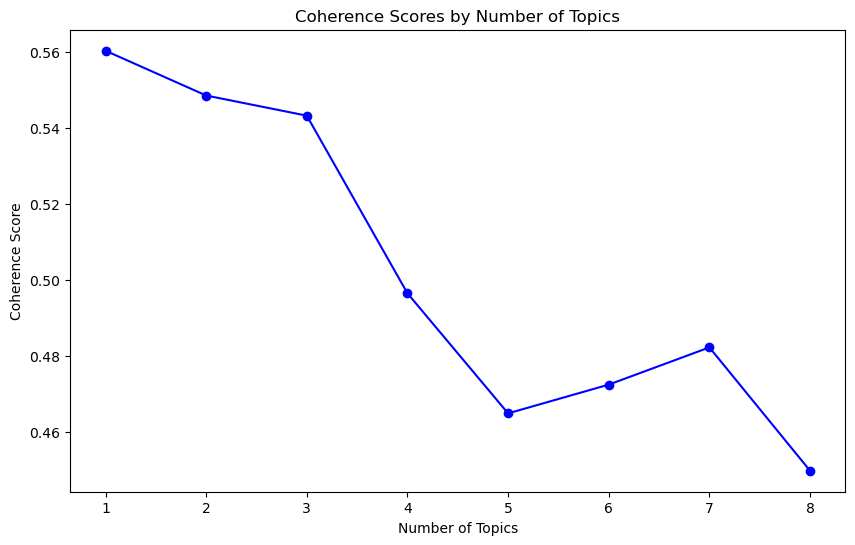

Best Number of Topics: 1 with Coherence Score: 0.5602083301818224


In [5]:
combined_coherence_scores_svd_tfidf = compute_coherence_scores_svd(recom_df['combined_context'], TfidfVectorizer(), range(1, 9, 1))

Number of Topics: 10, Coherence Score: 0.28978207893739194
Number of Topics: 11, Coherence Score: 0.2870600896375178
Number of Topics: 12, Coherence Score: 0.2905978074085674
Number of Topics: 13, Coherence Score: 0.29230767833949955
Number of Topics: 14, Coherence Score: 0.27468710447253114
Number of Topics: 15, Coherence Score: 0.29649402709391415
Number of Topics: 16, Coherence Score: 0.2831170641180883
Number of Topics: 17, Coherence Score: 0.2898984094719865
Number of Topics: 18, Coherence Score: 0.27873681422968327
Number of Topics: 19, Coherence Score: 0.2859551032442448
Number of Topics: 20, Coherence Score: 0.28163981667833893


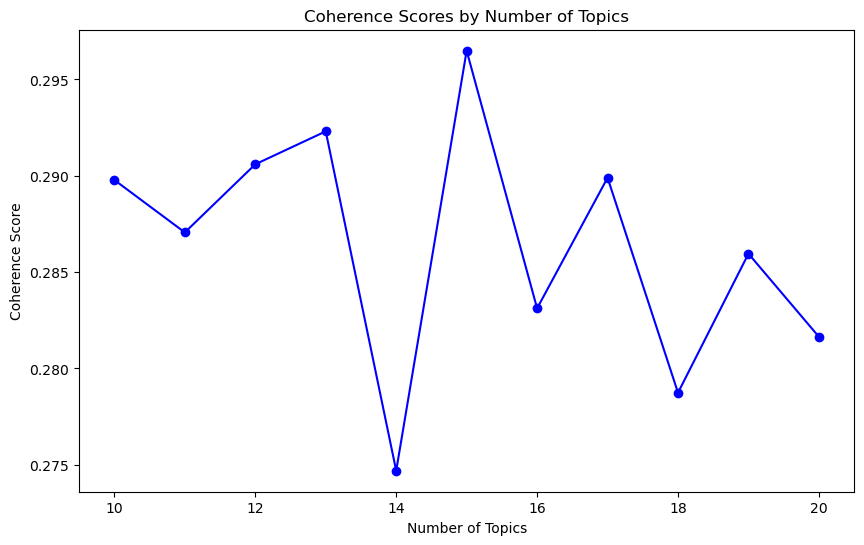

Best Number of Topics: 15 with Coherence Score: 0.29649402709391415


In [6]:
name_coherence_scores_svd_tfidf = compute_coherence_scores_svd(recom_df['processed_name'], TfidfVectorizer(), range(10, 21, 1))

Compare the performanc of the SVD on Count vectorizer using "combined_context" and "processed_name" columns separately

Number of Topics: 1, Coherence Score: 0.6075562077810124
Number of Topics: 2, Coherence Score: 0.6714039099628953
Number of Topics: 3, Coherence Score: 0.6783638424698181
Number of Topics: 4, Coherence Score: 0.619166633756616
Number of Topics: 5, Coherence Score: 0.5746820360916025
Number of Topics: 6, Coherence Score: 0.5571860169947346
Number of Topics: 7, Coherence Score: 0.536111833213606
Number of Topics: 8, Coherence Score: 0.5067632249536362
Number of Topics: 9, Coherence Score: 0.5071437101124506
Number of Topics: 10, Coherence Score: 0.49172193926773355


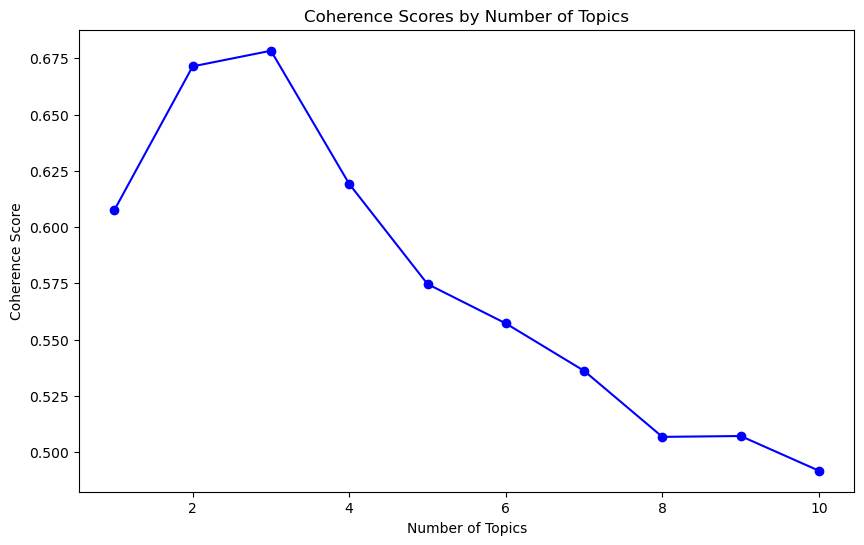

Best Number of Topics: 3 with Coherence Score: 0.6783638424698181


In [7]:
combined_coherence_scores_svd_countvect = compute_coherence_scores_svd(recom_df['combined_context'], CountVectorizer(), range(1, 11, 1))

Number of Topics: 1, Coherence Score: 0.32747617842211824
Number of Topics: 2, Coherence Score: 0.30166519834894745
Number of Topics: 3, Coherence Score: 0.36330030808995356
Number of Topics: 4, Coherence Score: 0.3480034982070445
Number of Topics: 5, Coherence Score: 0.3368158243804163
Number of Topics: 6, Coherence Score: 0.3183631931708423
Number of Topics: 7, Coherence Score: 0.3279089212236196
Number of Topics: 8, Coherence Score: 0.32264298398599245
Number of Topics: 9, Coherence Score: 0.3285419356338879
Number of Topics: 10, Coherence Score: 0.2974709760336278
Number of Topics: 11, Coherence Score: 0.30661562505313456
Number of Topics: 12, Coherence Score: 0.3180298562942133
Number of Topics: 13, Coherence Score: 0.3053436747424083
Number of Topics: 14, Coherence Score: 0.2998782239204906


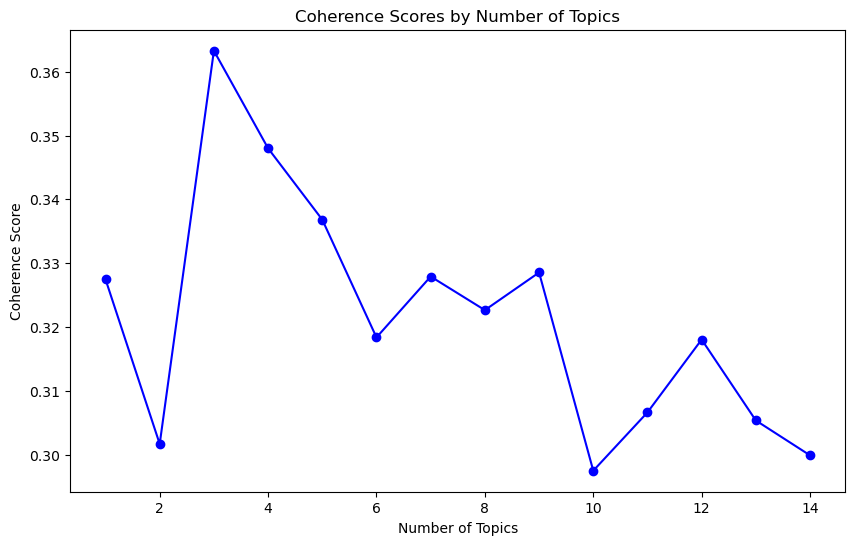

Best Number of Topics: 3 with Coherence Score: 0.36330030808995356


In [ ]:
name_coherence_scores_svd_countvect = compute_coherence_scores_svd(recom_df['processed_name'], CountVectorizer(), range(1, 11, 1))